In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\Titanic\train.csv')

In [3]:
# Count how many NaN values there are in each column
len(df_train) - df_train.count()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Passengers with missing values for Embarked and Fare.
df_train[df_train.drop(['Age','Cabin','Survived'],axis =1).isnull().any(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


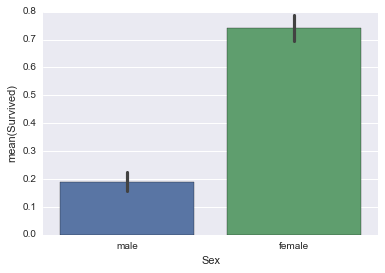

In [9]:
sns.barplot(x='Sex', y='Survived', data=df_train)

Let's first of all analyse the most obvious relationship, between sex, age and survival rate. The fist graph shows the strong relation between sex and survival rate. The relation is so strong that Kaggle sugest a simple model that returns 1 if the passenger is a female and 0 if it's a male. This model has a 76.6% accuracy.

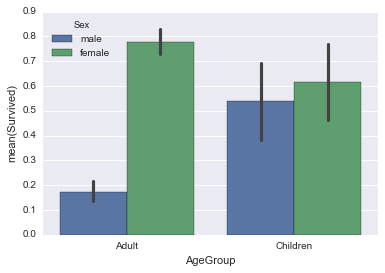

In [10]:
age_df = df_train[['Age','Survived', 'Sex']].copy()
age_df.loc[age_df.Age<15,'AgeGroup'] = 'Children'
age_df.loc[age_df.Age>=15,'AgeGroup'] = 'Adult'
sns.barplot(x='AgeGroup', y='Survived', hue='Sex', data=age_df)

When we divide the data by age groups, it's possible to notice, that the discrepancy between the survival rate of males and females almost desapers. The last plot shows the influence of both "Sex" and "Age" on the survival rate.

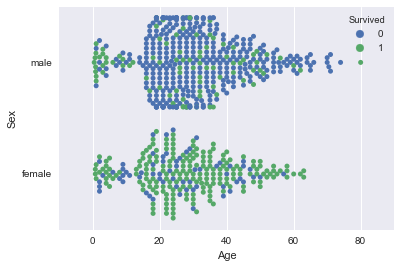

In [11]:
sns.swarmplot(x='Age',y='Sex',hue='Survived',data=df_train)

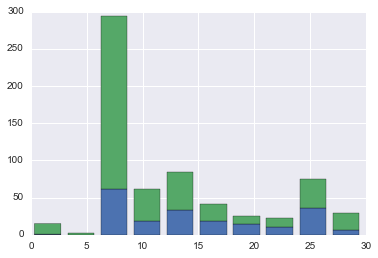

In [13]:
p = plt.hist([df_train[(df_train.Survived==1)&(df_train.Fare<30)].Fare, 
              df_train[(df_train.Survived==0)&(df_train.Fare<30)].Fare], histtype='bar', stacked=True, bins=10)

For the column Fare, however, it makes sense to fill in the NaN values with the mean by the column Pclass, or Passenger class.

In [14]:
fare_means = df_train.pivot_table('Fare', index='Pclass', aggfunc='mean')

In [15]:
fare_means

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

Here we created a pivot table by calculating the mean of the column Fare by each Pclass, which we will use to fill in our NaN values.

In [16]:
df_train['Fare'] = df_train[['Fare', 'Pclass']].apply(lambda x:
                            fare_means[x['Pclass']] if pd.isnull(x['Fare'])
                            else x['Fare'], axis=1)

First, we look at each of the pairs (Fare, Pclass) (i.e. lambda x). From this pair, we check if the Fare part is NaN (i.e. if pd.isnull(x['Fare'])). If Fare is NaN, we look at the Pclass value of that pair (i.e. x['PClass']), and replace the NaN value the mean fare of that class (i.e. fare_means[x['Pclass']]). If Fare is not NaN, then we keep it the same (i.e. else x['Fare']).

For the column Embarked, however, replacing {C, S, Q} by {1, 2, 3} would seem to imply the ordering C < S < Q when in fact they are simply arranged alphabetically.
To avoid this problem, we create dummy variables. Essentially this involves creating new columns to represent whether the passenger embarked at C with the value 1 if true, 0 otherwise. Pandas has a built-in function to create these columns automatically.

In [18]:
pd.get_dummies(df_train['Embarked'], prefix='Embarked').head(3)

,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0


We now concatenate the columns containing the dummy variables to our main dataframe.

In [19]:
pd.concat([df_train, pd.get_dummies(df_train['Embarked'], prefix='Embarked')], axis=1)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0.0,1.0,0.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.0,0.0,1.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0.0,0.0,1.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0.0,0.0,1.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1.0,0.0,0.0


In [21]:
import re
#Creating a new variable which denotes the salutation
def parse_des(x):
    x=re.findall(r',\s\w+.',x)
    return (re.findall(r'\w+',str(x)))[0]
df_train['desig']=df_train['Name'].apply(parse_des)


#checking all the salutation that are extracted from the data
df_train.desig.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Ms            1
Sir           1
Mme           1
Jonkheer      1
the           1
Don           1
Lady          1
Capt          1
Name: desig, dtype: int64

In [22]:
# Load packages
import numpy as np  
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_style('whitegrid')

from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

print ("Read in packages from numpy, pandas, sklearn, seaborn & matplotlib")

Read in packages from numpy, pandas, sklearn, seaborn & matplotlib


In [23]:
# Load training data
train_set = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\Titanic\train.csv')
test_set  = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\Titanic\test.csv')
print ("Read in training, test data as Panda dataframes")

# Review input features - Part 1
print ("\n\n---------------------")
print ("TRAIN SET INFORMATION")
print ("---------------------")
print ("Shape of training set:", train_set.shape, "\n")
print ("Column Headers:", list(train_set.columns.values), "\n")
print (train_set.describe(), "\n\n")
print (train_set.dtypes)

print ("\n\n--------------------")
print ("TEST SET INFORMATION")
print ("--------------------")
print ("Shape of test set:", test_set.shape, "\n")
print ("Column Headers:", list(test_set.columns.values), "\n")
print (test_set.describe(), "\n\n")
print (test_set.dtypes)

Read in training, test data as Panda dataframes


---------------------
TRAIN SET INFORMATION
---------------------
Shape of training set: (891, 12) 

Column Headers: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] 

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594  

In [25]:
# Review input features (train set) - Part 2A
missing_values = []
nonumeric_values = []

print ("TRAINING SET INFORMATION")
print ("========================\n")

for column in train_set:
    # Find all the unique feature values
    uniq = train_set[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 25):
        print("~~Listing up to 25 unique values~~")
    print (uniq[0:24])
    print ("\n-----------------------------------------------------------------------\n")
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(train_set[column]).sum())
        missing_values.append(s)
    
    # Find features with non-numeric values
    for i in range (1, np.prod(uniq.shape)):
        if (re.match('nan', str(uniq[i]))):
            break
        if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
            nonumeric_values.append(column)
            break
  
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print ("Features with missing values:\n{}\n\n" .format(missing_values))
print ("Features with non-numeric values:\n{}" .format(nonumeric_values))
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
# Review input features (test set) - Part 2B
missing_values = []
nonumeric_values = []

print ("TEST SET INFORMATION")
print ("====================\n")

for column in test_set:
    # Find all the unique feature values
    uniq = test_set[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 25):
        print("~~Listing up to 25 unique values~~")
    print (uniq[0:24])
    print ("\n-----------------------------------------------------------------------\n")
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(test_set[column]).sum())
        missing_values.append(s)
    
    # Find features with non-numeric values
    for i in range (1, np.prod(uniq.shape)):
        if (re.match('nan', str(uniq[i]))):
            break
        if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
            nonumeric_values.append(column)
            break
  
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print ("Features with missing values:\n{}\n\n" .format(missing_values))
print ("Features with non-numeric values:\n{}" .format(nonumeric_values))
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

TRAINING SET INFORMATION

'PassengerId' has 891 unique values
~~Listing up to 25 unique values~~
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]

-----------------------------------------------------------------------

'Survived' has 2 unique values
[0 1]

-----------------------------------------------------------------------

'Pclass' has 3 unique values
[3 1 2]

-----------------------------------------------------------------------

'Name' has 891 unique values
~~Listing up to 25 unique values~~
['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)' 'Sandstrom, Miss. Marguerite Rut'
 'Bonnell, Miss. Elizabeth' 'Saundercock, Mr. William Henry'
 'Andersson, Mr. And

In [26]:
# Feature Cleaning
# Convert non-numeric values for Sex, Embarked
# male=0, female=1
train_set.loc[train_set["Sex"] == "male", "Sex"]   = 0
train_set.loc[train_set["Sex"] == "female", "Sex"] = 1

test_set.loc[test_set["Sex"] == "male", "Sex"]   = 0
test_set.loc[test_set["Sex"] == "female", "Sex"] = 1

# Handle Parch=9 found only in test
# replace by value 6 which is the closest available in training data
test_set.loc[test_set["Parch"] == 9, "Parch"] = 6

# S=0, C=1, Q=2
train_set.loc[train_set["Embarked"] == "S", "Embarked"] = 0
train_set.loc[train_set["Embarked"] == "C", "Embarked"] = 1
train_set.loc[train_set["Embarked"] == "Q", "Embarked"] = 2

test_set.loc[test_set["Embarked"] == "S", "Embarked"] = 0
test_set.loc[test_set["Embarked"] == "C", "Embarked"] = 1
test_set.loc[test_set["Embarked"] == "Q", "Embarked"] = 2

# Substitute missing values for Age, Embarked & Fare
train_set["Age"]      = train_set["Age"].fillna(train_set["Age"].median())
train_set["Fare"]     = train_set["Fare"].fillna(train_set["Fare"].median())
train_set["Embarked"] = train_set["Embarked"].fillna(train_set["Embarked"].median())

test_set["Age"] = test_set["Age"].fillna(test_set["Age"].median())
test_set["Fare"] = test_set["Fare"].fillna(test_set["Fare"].median())

print ("Converted non-numeric features for Sex & Embarked...\nSubstituted missing values for Age, Embarked & Fare")

Converted non-numeric features for Sex & Embarked...
Substituted missing values for Age, Embarked & Fare


VISUALIZING TRAINING DATA - FEATURES vs OUTCOME


Tables for Pclass

Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

Survived         0         1
Pclass                      
1         0.370370  0.629630
2         0.527174  0.472826
3         0.757637  0.242363

-----------------------------------

Tables for Sex

Survived    0    1
Sex               
0         468  109
1          81  233

Survived         0         1
Sex                         
0         0.811092  0.188908
1         0.257962  0.742038

-----------------------------------

Tables for Embarked

Survived    0    1
Embarked          
0.0       427  219
1.0        75   93
2.0        47   30

Survived         0         1
Embarked                    
0.0       0.660991  0.339009
1.0       0.446429  0.553571
2.0       0.610390  0.389610

-----------------------------------

Tables for SibSp

Survived    0    1
SibSp             
0         398  210
1          97  112
2          

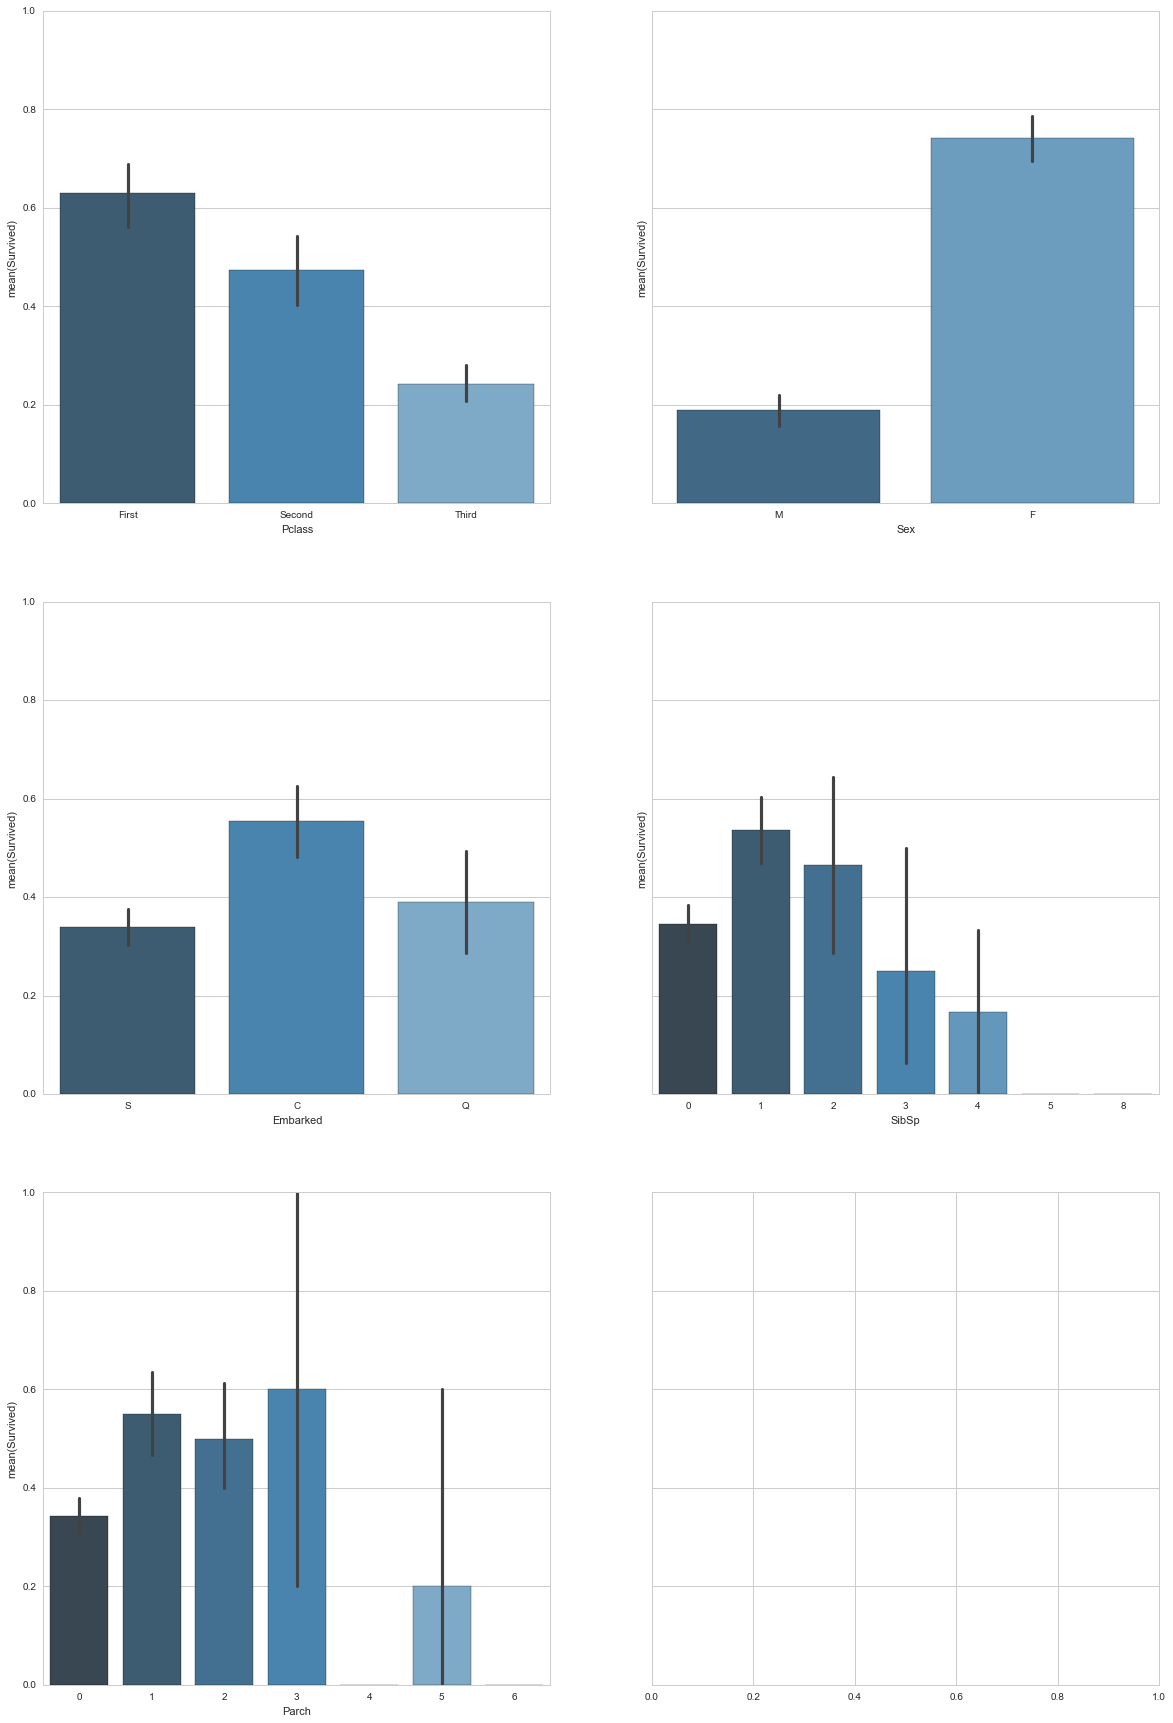

In [27]:
# Pclass - Visualize the features and their impact on outcomes
# Two subplots, the axes array is 1-d
print ("VISUALIZING TRAINING DATA - FEATURES vs OUTCOME")
print ("===============================================\n\n")

f, ((axis1,axis2), (axis3,axis4), (axis5,axis6)) = plt.subplots(3,2, sharey=True, figsize=(20,30))

sns.barplot(x='Pclass', y='Survived', data=train_set, order=[1, 2, 3], ax=axis1, palette="Blues_d")
axis1.set_xticklabels(['First', 'Second', 'Third'], rotation=0)

sns.barplot(x='Sex', y='Survived', data=train_set, order=[0, 1], ax=axis2, palette="Blues_d")
axis2.set_xticklabels(['M', 'F'], rotation=0)

sns.barplot(x='Embarked', y='Survived', data=train_set, order=[0, 1, 2], ax=axis3, palette="Blues_d")
axis3.set_xticklabels(['S', 'C', 'Q'], rotation=0)

sns.barplot(x='SibSp', y='Survived', data=train_set, order=[0, 1, 2, 3, 4, 5, 8], ax=axis4, palette="Blues_d")

sns.barplot(x='Parch', y='Survived', data=train_set, order=[0, 1, 2, 3, 4, 5, 6], ax=axis5, palette="Blues_d")


# Print survival rate for each feature
for feature in ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']:
    feature_survived = pd.crosstab(train_set[feature], train_set["Survived"])
    feature_survived_frac = feature_survived.apply(lambda r: r/r.sum(), axis=1)
    print ("Tables for {}\n\n{}\n\n{}\n" .format(feature, feature_survived, feature_survived_frac))
    print ("-----------------------------------\n")

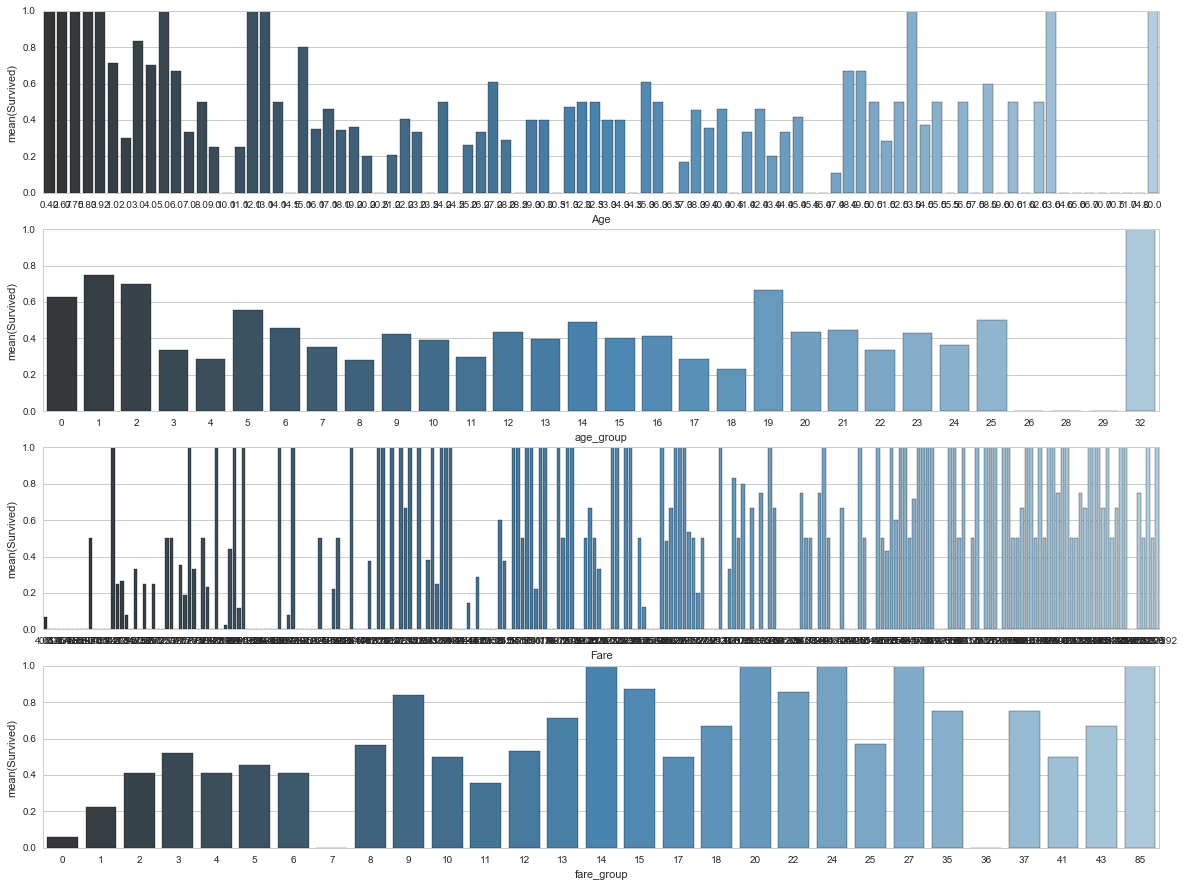

In [28]:
# Longer X-Axis for age, fare
f, (axis1,axis2,axis3,axis4) = plt.subplots(4,1, sharey=True, figsize=(20,15))
survival_by_age = train_set[['Age', 'Survived']].groupby(['Age'],as_index=False).mean() 
sns.barplot(x='Age', y='Survived', data=survival_by_age, ax=axis1, palette="Blues_d")

train_set['age_group'] = train_set.apply(lambda r: int(r.Age/2.5), axis=1)
test_set['age_group']  = test_set.apply(lambda r: int(r.Age/2.5), axis=1)
survival_by_agegroup = train_set[['age_group', 'Survived']].groupby(['age_group'],as_index=False).mean() 
sns.barplot(x='age_group', y='Survived', data=survival_by_agegroup, ax=axis2, palette="Blues_d")

survival_by_fare = train_set[['Fare', 'Survived']].groupby(['Fare'],as_index=False).mean() 
sns.barplot(x='Fare', y='Survived', data=survival_by_fare, ax=axis3, palette="Blues_d")

train_set['fare_group'] = train_set.apply(lambda r: int(r.Fare/6.0), axis=1)
test_set['fare_group']  = test_set.apply(lambda r: int(r.Fare/6.0), axis=1)
survival_by_faregroup = train_set[['fare_group', 'Survived']].groupby(['fare_group'],as_index=False).mean() 
sns.barplot(x='fare_group', y='Survived', data=survival_by_faregroup, ax=axis4, palette="Blues_d")

In [29]:
# Features used for training
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_group', 'fare_group']

# Train / Test split for original training data
# Withold 5% from train set for testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    train_set[predictors], train_set["Survived"], test_size=0.05, random_state=0)

print ("Original Training Set: {}\nTraining Set: {}\nTesting Set(witheld): {}" .format(train_set.shape, X_train.shape,X_test.shape))


# Normalize features - both training & test (withheld & final)
scaler = StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
final_test_transformed  = scaler.transform(test_set[predictors])

print ("Transformed training, test sets (withheld & final)")

# Scoring Metric - Accuracy
print ("Use accuracy as the score function")

Original Training Set: (891, 14)
Training Set: (846, 9)
Testing Set(witheld): (45, 9)
Transformed training, test sets (withheld & final)
Use accuracy as the score function


In [30]:
X_new = np.delete(X_train_transformed, [1,3], axis=1)
X_new.shape
X_train_transformed.shape

(846, 9)

 1) Sex                            0.480577
 2) Fare                           0.172835
 3) Pclass                         0.139670
 4) Age                            0.108588
 5) SibSp                          0.037490
 6) Parch                          0.032357
 7) Embarked                       0.028481


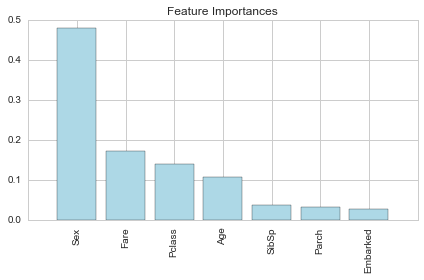

In [31]:
# Assess Feature importance
# Initialize the algorithm
# Defaults to mean accuracy as score
feature_labels = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_train1 = np.delete(X_train_transformed, [7,8], axis=1)

alg = RandomForestClassifier(random_state=1, n_estimators=10000, min_samples_split=50, min_samples_leaf=1)
clf = alg.fit(X_train1, y_train)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train1.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [ feature_labels[i] for i in indices]
    
plt.title('Feature Importances')
plt.bar(range(X_train1.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(X_train1.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, X_train1.shape[1]])
plt.tight_layout()
plt.show()

In [32]:
# Assess Feature importance
# Initialize the algorithm
# Defaults to mean accuracy as score
feature_labels = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'age_group', 'fare_group']
X_train2 = np.delete(X_train_transformed, [2,5], axis=1)

In [33]:
X_train2

array([[ 0.82376881, -0.73551588, -0.47635936, ..., -0.56453719,
        -0.08014224, -0.47500839],
       [ 0.82376881, -0.73551588, -0.47635936, ..., -0.56453719,
        -0.08014224, -0.47500839],
       [-1.57522745,  1.35958996,  1.32677272, ...,  1.00651038,
        -0.84194379,  4.60719522],
       ..., 
       [ 0.82376881, -0.73551588, -0.47635936, ...,  2.57755795,
        -0.08014224, -0.47500839],
       [ 0.82376881,  1.35958996,  0.42520668, ..., -0.56453719,
         0.49120892, -0.35400354],
       [-0.37572932, -0.73551588,  0.42520668, ..., -0.56453719,
         2.39571279,  0.13001585]])

 1) Sex                            0.502084
 2) Pclass                         0.149220
 3) fare_group                     0.136340
 4) age_group                      0.106409
 5) SibSp                          0.039492
 6) Parch                          0.035510
 7) Embarked                       0.030945


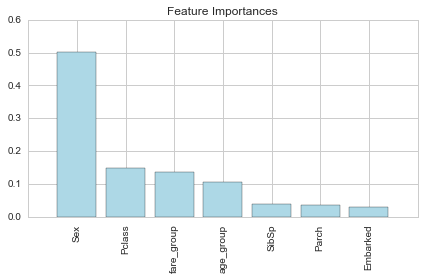

In [34]:
alg = RandomForestClassifier(random_state=1, n_estimators=10000, min_samples_split=50, min_samples_leaf=1)
clf = alg.fit(X_train2, y_train)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train2.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [ feature_labels[i] for i in indices]
    
plt.title('Feature Importances')
plt.bar(range(X_train2.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(X_train2.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, X_train2.shape[1]])
plt.tight_layout()
plt.show()

In [35]:
# Use a simple model
# Initialize the algorithm
# Defaults to mean accuracy as score
alg = RandomForestClassifier(random_state=1, n_estimators=200, min_samples_split=5, min_samples_leaf=3)
clf = alg.fit(X_train_transformed, y_train)

# Scores
train_score = clf.score(X_train_transformed, y_train)
test_score  = clf.score(X_test_transformed, y_test)
print ("Train Score: %0.3f\nTest Score: %0.3f" %(train_score, test_score))

Train Score: 0.909
Test Score: 0.867


In [36]:
# Use Cross Validation
scores = cross_validation.cross_val_score(clf, X_train_transformed, y_train, cv=3)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
# Use GridSearchCV
# Specify parameters
param_grid = {"n_estimators": [200, 300, 500],
              "max_depth": [None],
              "max_features": [5],
              "min_samples_split": [9],
              "min_samples_leaf": [6],
              "bootstrap": [True],
              "criterion": ["gini"]}
             
clf = RandomForestClassifier()

grid_search = GridSearchCV(clf, param_grid=param_grid)
grid_search.fit(X_train_transformed, y_train)
print (grid_search.best_estimator_) 

# Scores
train_score = grid_search.score(X_train_transformed, y_train)
test_score  = grid_search.score(X_test_transformed, y_test)
print ("Train Score: %0.3f\nTest Score: %0.3f" %(train_score, test_score))

Accuracy: 0.825 (+/- 0.023)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_samples_leaf=6, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Train Score: 0.879
Test Score: 0.844


In [37]:
# Use Random Forest with Best Parameters
clf_final = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_samples_leaf=6, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf_final.fit(X_train_transformed, y_train)

# Scores
train_score = clf_final.score(X_train_transformed, y_train)
test_score  = clf_final.score(X_test_transformed, y_test)
print ("Train Score: %0.3f\nTest Score: %0.3f" %(train_score, test_score))

#CV
scores = cross_validation.cross_val_score(clf_final, X_train_transformed, y_train, cv=3)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Train Score: 0.881
Test Score: 0.844
Accuracy: 0.814 (+/- 0.018)


In [38]:
# Make Predictions using Test Set
predictions = clf_final.predict(final_test_transformed)

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test_set["PassengerId"],
        "Survived": predictions
    })
submission.to_csv('titanic_rf4.csv', index=False)

submission.head(3)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0


In [39]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [40]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\Titanic\train.csv', dtype={"Age": np.float64}, )
test_df    = pd.read_csv(, dtype={"Age": np.float64}, )

In [41]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

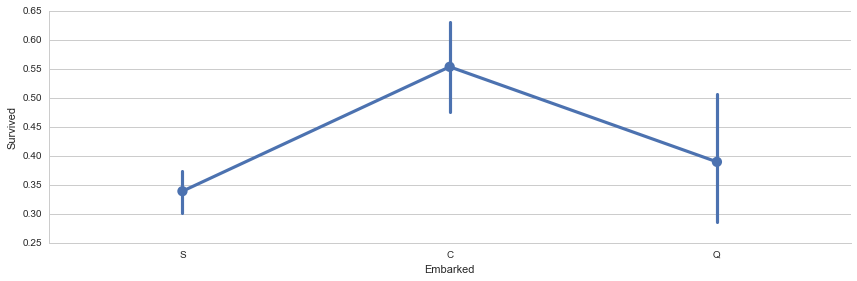

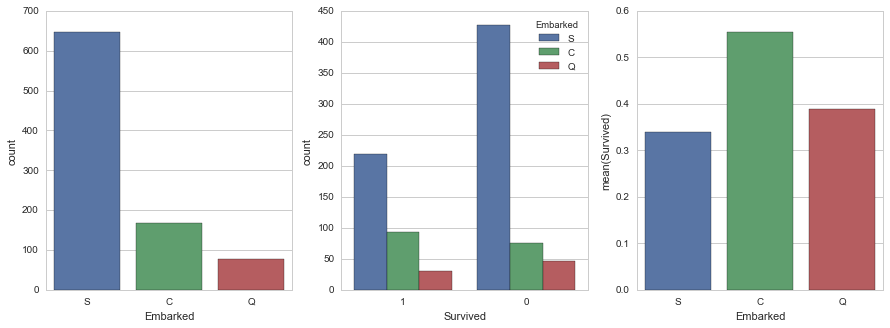

In [42]:
# Embarked

# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# plot
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# sns.factorplot('Embarked',data=titanic_df,kind='count',order=['S','C','Q'],ax=axis1)
# sns.factorplot('Survived',hue="Embarked",data=titanic_df,kind='count',order=[1,0],ax=axis2)
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


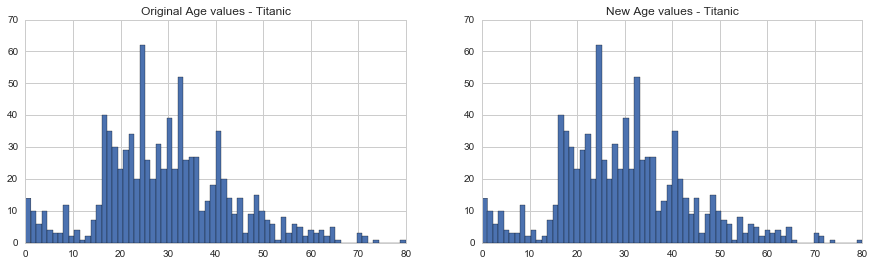

In [43]:
# Age 

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# axis3.set_title('Original Age values - Test')
# axis4.set_title('New Age values - Test')

# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# fill NaN values in Age column with random values generated
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

# plot original Age values
titanic_df['Age'].hist(bins=70, ax=axis1)
# test_df['Age'].hist(bins=70, ax=axis3)
        
# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)
# test_df['Age'].hist(bins=70, ax=axis4)

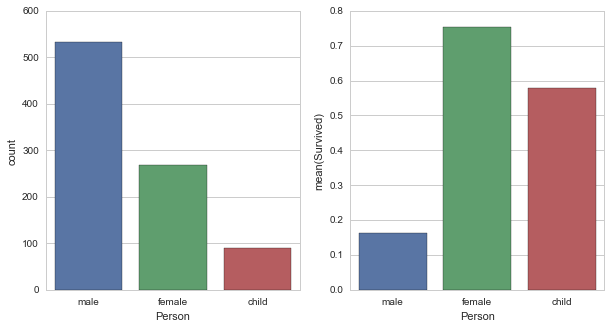

In [46]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

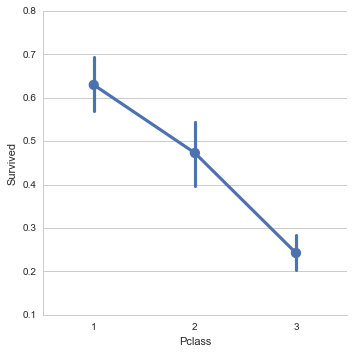

In [50]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

In [51]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [53]:
# Logistic Regression

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

ValueError: could not convert string to float: 'C148'

In [56]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = pd.DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [58]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)

NameError: name 'Y_pred' is not defined

In [63]:
#Load training data

df = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\Titanic\train.csv')

In [64]:
#People with stronger titles tend to have more help on board. Hence, we will categorize passengers based on titles.
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    } 

df['Title'] = df['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])

In [65]:
#The ticket prefix may determine the status or cabin on board and hence will be included
def Ticket_Prefix(s):
    s=s.split()[0]
    if s.isdigit():
        return 'NoClue'
    else:
        return s

df['TicketPrefix'] = df['Ticket'].apply(lambda x: Ticket_Prefix(x))

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Name            891 non-null object
Sex             891 non-null object
Age             714 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Ticket          891 non-null object
Fare            891 non-null float64
Cabin           204 non-null object
Embarked        889 non-null object
Title           891 non-null object
TicketPrefix    891 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 97.5+ KB


In [67]:
#We add in the median age based on the Title, Pclass and Sex of each passenger.
mask_Age = df.Age.notnull()
Age_Sex_Title_Pclass = df.loc[mask_Age, ["Age", "Title", "Sex", "Pclass"]]
Filler_Ages = Age_Sex_Title_Pclass.groupby(by = ["Title", "Pclass", "Sex"]).median()
Filler_Ages = Filler_Ages.Age.unstack(level = -1).unstack(level = -1)

mask_Age = df.Age.isnull()
Age_Sex_Title_Pclass_missing = df.loc[mask_Age, ["Title", "Sex", "Pclass"]]

def Age_filler(row):
    if row.Sex == "female":
        age = Filler_Ages.female.loc[row["Title"], row["Pclass"]]
        return age
    
    elif row.Sex == "male":
        age = Filler_Ages.male.loc[row["Title"], row["Pclass"]]
        return age
    
Age_Sex_Title_Pclass_missing["Age"]  = Age_Sex_Title_Pclass_missing.apply(Age_filler, axis = 1)   

df["Age"] = pd.concat([Age_Sex_Title_Pclass["Age"], Age_Sex_Title_Pclass_missing["Age"]])    


In [68]:
df['Fare']=df['Fare'].fillna(value=df.Fare.mean())

In [69]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df = df.drop(['Ticket', 'Cabin'], axis=1)

In [70]:
#Now we deal with categorical data using dummy variables.
dummies_Sex=pd.get_dummies(df['Sex'],prefix='Sex')
dummies_Embarked = pd.get_dummies(df['Embarked'], prefix= 'Embarked') 
dummies_Pclass = pd.get_dummies(df['Pclass'], prefix= 'Pclass')
dummies_Title = pd.get_dummies(df['Title'], prefix= 'Title')
dummies_TicketPrefix = pd.get_dummies(df['TicketPrefix'], prefix='TicketPrefix')
df = pd.concat([df, dummies_Sex, dummies_Embarked, dummies_Pclass, dummies_Title, dummies_TicketPrefix], axis=1)
df = df.drop(['Sex','Embarked','Pclass','Title','Name','TicketPrefix'], axis=1)

In [71]:
df = df.set_index(['PassengerId'])
df.head()

,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,TicketPrefix_SOTON/O.Q.,TicketPrefix_SOTON/O2,TicketPrefix_SOTON/OQ,TicketPrefix_STON/O,TicketPrefix_STON/O2.,TicketPrefix_SW/PP,TicketPrefix_W./C.,TicketPrefix_W.E.P.,TicketPrefix_W/C,TicketPrefix_WE/P
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,38.0,1,0,71.2833,1,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,26.0,0,0,7.9250,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,35.0,1,0,53.1000,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,35.0,0,0,8.0500,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For feature selection, we will look at the correlation of each feature against Survived. Based on our data types, we will use the following aglorithms:

    Spearman-Rank correlation for nominal vs nominal data

    Point-Biserial correlation for nominal vs continuous data

In [73]:
from scipy.stats import pointbiserialr, spearmanr
columns = df.columns.values

param=[]
correlation=[]
abs_corr=[]

for c in columns:
    #Check if binary or continuous
    if len(df[c].unique())<=2:
        corr = spearmanr(df['Survived'],df[c])[0]
    else:
        corr = pointbiserialr(df['Survived'],df[c])[0]
    param.append(c)
    correlation.append(corr)
    abs_corr.append(abs(corr))

#Create dataframe for visualization
param_df=pd.DataFrame({'correlation':correlation,'parameter':param, 'abs_corr':abs_corr})

#Sort by absolute correlation
param_df=param_df.sort_values(by=['abs_corr'], ascending=False)

#Set parameter name as index
param_df=param_df.set_index('parameter')

param_df.head()

,abs_corr,correlation
parameter,,
Survived,1.000000,1.000000
Title_Mr,0.549199,-0.549199
Sex_male,0.543351,-0.543351
Sex_female,0.543351,0.543351
Title_Mrs,0.344935,0.344935


In [74]:
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

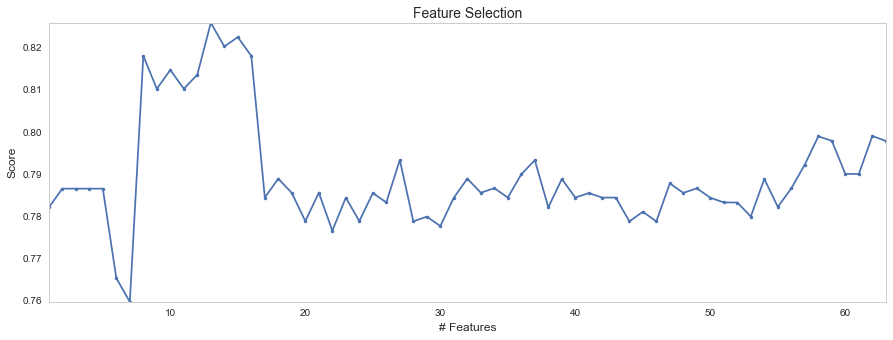

In [78]:
#Now that we have our correlation, we can use the Decision Tree classifier to see the score agaisnt feature space.
scoresCV = []
scores = []

for i in range(1,len(param_df)):
    new_df=df[param_df.index[0:i+1].values]
    X = new_df.ix[:,1::]
    y = new_df.ix[:,0]
    clf = DecisionTreeClassifier()
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.figure(figsize=(15,5))
plt.plot(range(1,len(scores)+1),scores, '.-')
plt.axis("tight")
plt.title('Feature Selection', fontsize=14)
plt.xlabel('# Features', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid();

Based on the plot, a feature space of 10 dimensions provides the most reliable result while avoiding overfit.

In [79]:
best_features=param_df.index[1:10+1].values
print('Best features:\t',best_features)

Best features:	 ['Title_Mr' 'Sex_male' 'Sex_female' 'Title_Mrs' 'Title_Miss' 'Pclass_3'
 'Pclass_1' 'Fare' 'Embarked_C' 'Embarked_S']


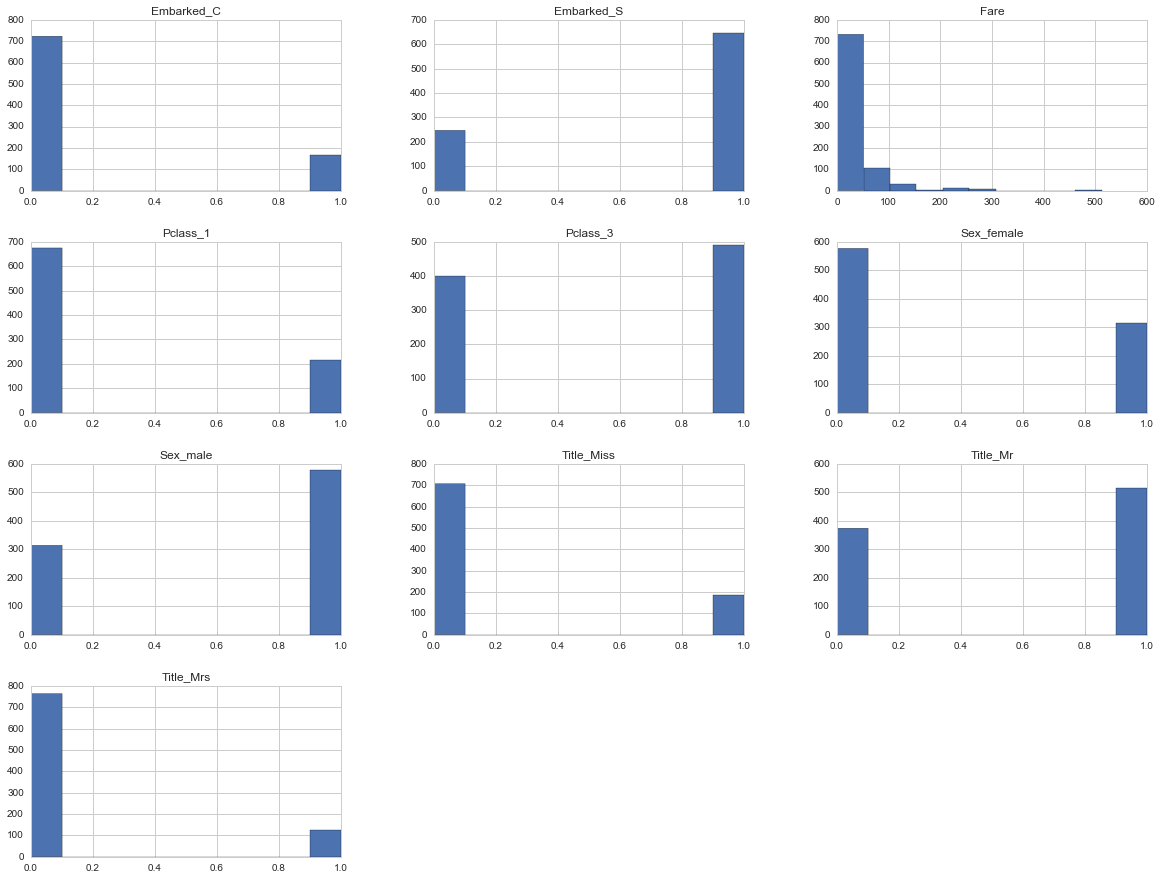

In [80]:
#Looking at out best features.

df[best_features].hist(figsize=(20,15));

In [81]:
#Creating the train and test datasets.

X = df[best_features]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)

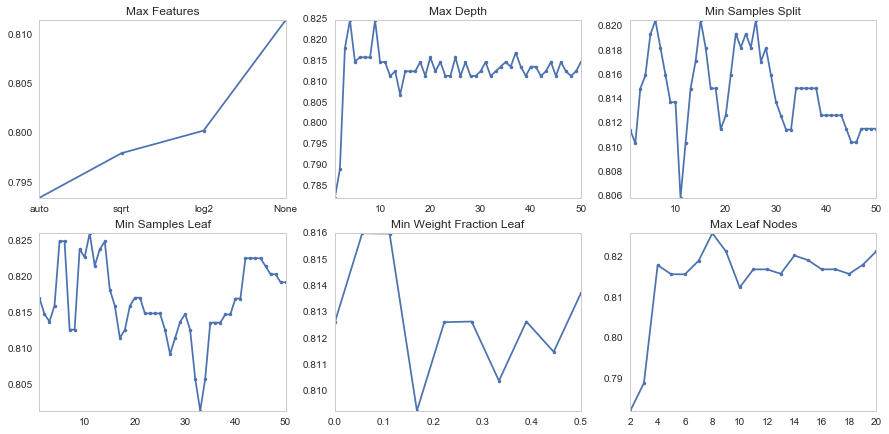

In [82]:
#Analyzing the different parameters of Decision Trees.

plt.figure(figsize=(15,7))

#Max Features
plt.subplot(2,3,1)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(2,3,2)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(2,3,3)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Samples Leaf
plt.subplot(2,3,4)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Leaf')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(2,3,5)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(2,3,6)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

Max Depth show high score variance with change in parameter.

All other parameters show low score variance.

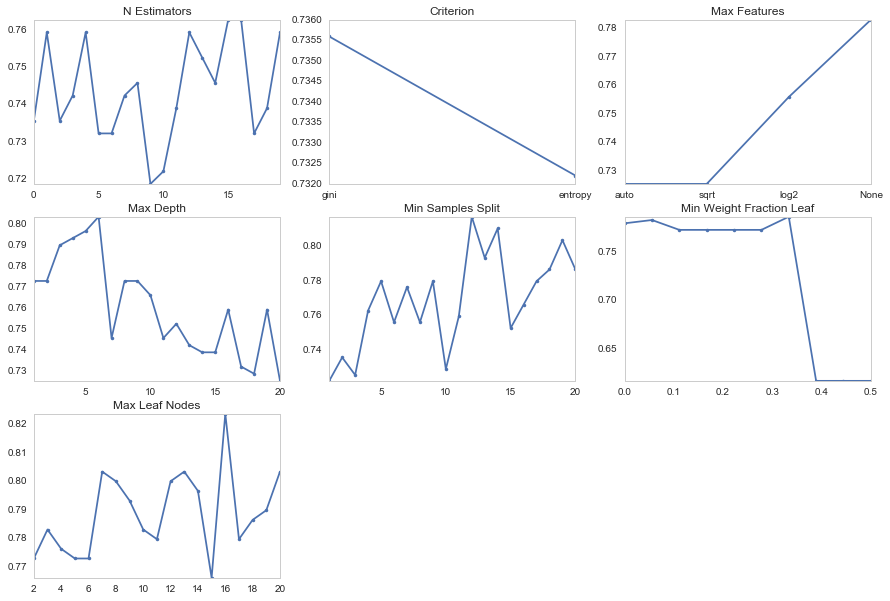

In [84]:
#Analyzing the different parameters of Random Forest Classifier.
plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('N Estimators')
plt.grid();

#Criterion
plt.subplot(3,3,2)
feature_param = ['gini','entropy']
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(criterion=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Criterion')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(3,3,4)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

Random Forest seems to show high variance in scores with most parameter changes.

Max Features, Criterion and Max Leaf Nodes show low variance in scores.

The general high varience in N Estimator plot shows the risk of overfitting.

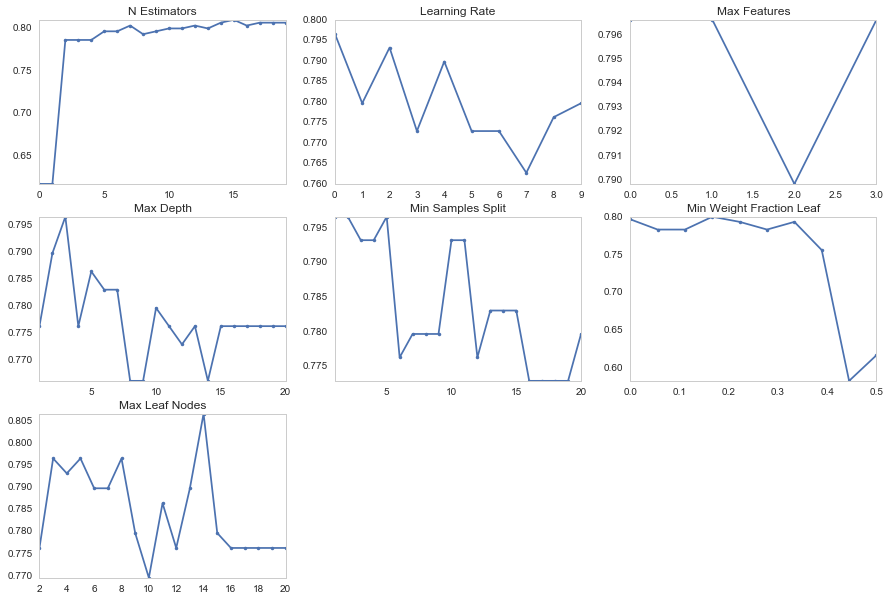

In [85]:
#Analyzing the different parameters of Gradient Boosting.

plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('N Estimators')
plt.grid();

#Learning Rate
plt.subplot(3,3,2)
feature_param = np.linspace(0.1,1,10)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(learning_rate=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Learning Rate')
plt.grid();

#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.grid();

#Max Depth
plt.subplot(3,3,4)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();


The N Estimator plot seems very stable and hence resistant to overfitting.

Min Weight Fraction Leaf drops significantly after a certain point.

All other plots show very little variance.


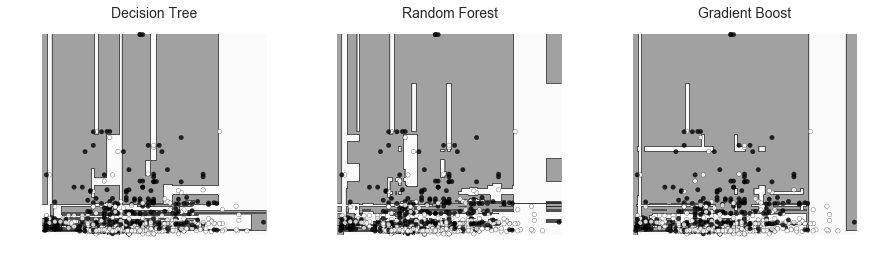

In [86]:
#Decision Surface
#Plotting dicision boundries with columns Age and Fare. 
from itertools import product

#Picking Age and Fare as they are continuous and highly correlated with Survived
X = df[['Age', 'Fare']].values
y = df['Survived'].values

# Training classifiers
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = GradientBoostingClassifier()

#Fit models
clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,4))

for idx, clf, tt in zip(range(3),
                        [clf1, clf2, clf3],
                        ['Decision Tree', 'Random Forest',
                         'Gradient Boost']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    axarr[idx].set_title(tt, fontsize=14)
    axarr[idx].axis('off')

All 3 plots are similar on the right side in terms of classification by initially splitting at Age. The second split occurs at the bottom for Fare. Discrepensies in classification occur as we move further than 2 splits. As more branches are forming, Decision Tree and Random Forest risk overfitting as they try to form more pure leaves. Relatively, Gradient Boost seem to be forming less branches and hence resistant to overfitting.